In [1]:
# !pip install -U matplotlib --quiet
# !pip install torch --quiet
# !pip install lightning --quiet

In [2]:
# !git clone https://github.com/QMCSoftware/QMCSoftware
# !cd QMCSoftware && git checkout qmctoolscl_integration
# !cd QMCSoftware && git pull
# !cd QMCSoftware && pip install -e .

# CHONKNORIS for a 1 dimensional non-linear elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 v^3 + C_2 \Delta v = u, & x \in [0,1] \\ v = 0, &x \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian, $u$ is random and $v$ is the unknown PDE solution.    

In [3]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # cholesky not implemented on MPS, fall back to CPU
import torch

In [4]:
# may need to Runtime > Restart session if loading for the first time on Google Colab
import torch
import qmcpy as qp
import pandas as pd
import numpy as np
import lightning
import gpytorch
import time
from collections import OrderedDict
import os
import glob
import warnings
from typing import List

In [5]:
ROOT = "."
assert os.path.isfile(ROOT+"/elliptic_pde_1d.ipynb")

In [6]:
assert torch.cuda.is_available() or torch.backends.mps.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "mps"
DEVICE

'cuda'

In [7]:
from matplotlib import pyplot,cm,colors,gridspec
#print(pyplot.style.available)
pyplot.style.use('seaborn-v0_8-whitegrid') 
LW = 3 # linewidth
LWTHIN = 0.01
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()]

## Reference Solution

We will randomly generate
$$v(x) = \exp\left(-\frac{1}{1-r(x)^2}\right)\left[\sum_{p=1}^P a_p \sin(p \pi x)\right] 1_{x \in (0,1)}$$
where $r(x)=2x-1$ and $(a_1,\dots,a_P) \sim \mathcal{U}[-\overline{B},\underline{B}]^P$. We will use auto-diff to find $u$.

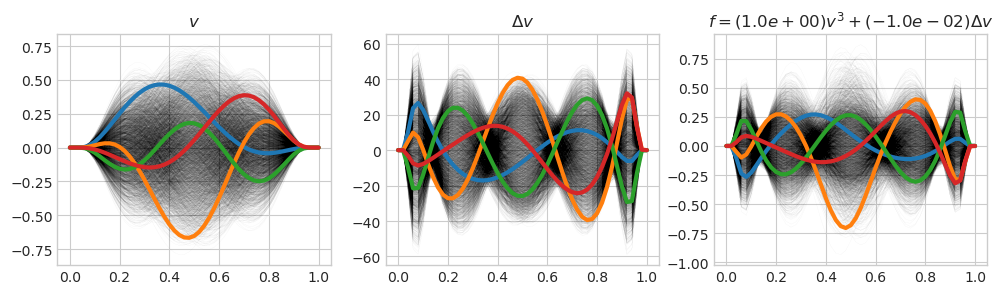

In [8]:
C1 = 1.
C2 = -1./100
def v(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    P = len(a)
    assert a.shape==(P,)
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = (a[:,None]*torch.sin(torch.arange(1,P+1)[:,None]*torch.pi*x[None,b])).sum(0)
    y[b] = t1*t2
    return y
def v_laplace(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    xg = x.clone().requires_grad_()
    yg = v(xg,a)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def u(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    return C1*v(x,a)**3+C2*v_laplace(x,a)
R = 2**12
P = 3
B_low = -1.
B_high = 1.
dnb2 = qp.DigitalNetB2(P,seed=7,graycode=True,t_lms=32)
unif_dnb2 = qp.Uniform(dnb2,lower_bound=B_low,upper_bound=B_high)
a = torch.from_numpy(unif_dnb2.gen_samples(R))
nxticks = 51
xticks = torch.linspace(0,1,nxticks,dtype=float)
vticks = torch.vstack([v(xticks,a=a[r]) for r in range(R)])
vlticks = torch.vstack([v_laplace(xticks,a=a[r]) for r in range(R)])
uticks = torch.vstack([u(xticks,a=a[r]) for r in range(R)])
if True:
    fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
    coloridxs = torch.arange(4)
    ax[0].plot(xticks,vticks.T,color='k',linewidth=LWTHIN)
    ax[1].plot(xticks,vlticks.T,color='k',linewidth=LWTHIN)
    ax[2].plot(xticks,uticks.T,color='k',linewidth=LWTHIN)
    ax[0].plot(xticks,vticks.T[:,coloridxs],linewidth=LW)
    ax[1].plot(xticks,vlticks.T[:,coloridxs],linewidth=LW)
    ax[2].plot(xticks,uticks.T[:,coloridxs],linewidth=LW)
    ax[0].set_title(r"$v$")
    ax[1].set_title(r"$\Delta v$")
    ax[2].set_title(r"$f = (%.1e) v^3 + (%.1e) \Delta v$"%(C1,C2));

## GP for PDE Solves

In [9]:
llbetas = [ # derivative orders
    [ # interior
        torch.tensor([[0]],dtype=int), # v
        torch.tensor([[2]],dtype=int), # laplacian v
    ],
    [ # boundary
        torch.tensor([[0]],dtype=int) # v
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # v
        torch.ones(1,dtype=float) # laplacian v
    ],
    [ # boundary
        torch.ones(1,dtype=float) # v
    ]
]
xs = [xticks[:,None],torch.tensor([[0],[1]],dtype=float)]

In [10]:
noise = 1e-8
lattice = qp.Lattice(dimension=1,seed=7) # collocation points
#kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
kernel = qp.KernelGaussian(dimension=1,lengthscales=1e-3,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(kernel,xs,None,None,llbetas,llcs,noise) # kernel interpolant

iter avg l2rerrs: [1.         0.71375368 0.26432571 0.07012188 0.01167968 0.00171043
 0.00108447 0.00108123 0.00108124 0.00108124 0.00108124]


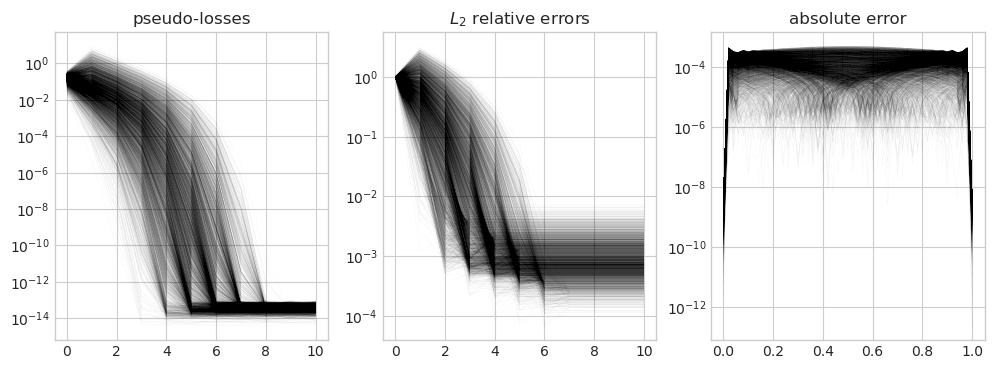

In [11]:
kvec = ki.get_new_left_full_gram_matrix(xticks[:,None])
def get_data(maxiter=10, tag="full", force_gen=False):
    fname = "%s/%s.%s"%(ROOT,"elliptic_pde_1d_data",tag)
    if (not os.path.exists(fname+".npz")) or force_gen:
        data = {
            "vopt": np.empty((R,maxiter+1,ki.length)),
            "losses_opt": np.empty((R,maxiter+1)),
            "vhats": np.empty((R,maxiter+1,nxticks)),
            "l2relerrors": np.empty((R,maxiter+1)),
            "L_chols": np.empty((R,maxiter,ki.ntot,ki.ntot))}
        print("r from 0 to %d, l2 relative errors\n"%(R)+"~"*100)
        verbosity = R//16
        for r in range(R):
            if (r+1)%verbosity==0: print("r = %d: "%(r+1),end='',flush=True)
            def pde_lhs_r(ly_i, ly_b):
                v_i,v_laplace_i = ly_i
                v_b = ly_b[0]
                lhs_i = C1*v_i**3+C2*v_laplace_i
                lhs_b = v_b
                return lhs_i,lhs_b
            def pde_rhs_r(x_i, x_b):
                y_i = uticks[r]
                y_b = torch.zeros(len(x_b),dtype=float)
                return y_i,y_b
            y,data_r = ki.pde_opt_gauss_newton(
                pde_lhs = pde_lhs_r,
                pde_rhs = pde_rhs_r,
                maxiter = maxiter,
                store_L_chol_hist = True,
                verbose = False)
            data["vopt"][r] = data_r["zhist"].numpy()
            data["losses_opt"][r] = data_r["losses"].numpy()
            data["vhats"][r] = (kvec@ki._solve(data_r["zhist"].T)).T.numpy()
            data["l2relerrors"][r] = (torch.linalg.norm(data_r["zhist"][:,:nxticks]-vticks[r],dim=1)/torch.linalg.norm(vticks[r])).numpy()
            data["L_chols"][r] = data_r["L_chol_hist"].numpy()
            if (r+1)%verbosity==0:
                with np.printoptions(precision=1,threshold=8):
                    print(data["l2relerrors"][r])
        np.savez_compressed(fname,**data)
    data = np.load(fname+".npz")
    return (
        torch.from_numpy(data["vopt"]),
        torch.from_numpy(data["losses_opt"]),
        torch.from_numpy(data["l2relerrors"]),
        torch.from_numpy(data["L_chols"]))
maxiter = 10
vopt,losses_opt,l2rerrs,L_chols = get_data(maxiter=maxiter,tag="bigeasy",force_gen=False)
L_inv_chols = torch.linalg.solve_triangular(L_chols,torch.eye(L_chols.size(-1),dtype=L_chols.dtype),upper=False)
print("iter avg l2rerrs:",l2rerrs.mean(0).numpy())
best_idxs = losses_opt.argmin(1)
vopt_best = vopt[np.arange(R),best_idxs,:]
if True:
    fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,4))
    ax[0].set_title("pseudo-losses")
    ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T,color="k",linewidth=LWTHIN)
    ax[0].set_yscale("log",base=10)
    ax[1].set_title(r"$L_2$ relative errors")
    ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T,color="k",linewidth=LWTHIN)
    ax[1].set_yscale("log",base=10)
    ax[2].set_title("absolute error")
    ax[2].plot(xticks,torch.abs(vopt_best[:,:nxticks]-vticks).T,color="k",linewidth=LWTHIN)
    ax[2].set_yscale("log",base=10);

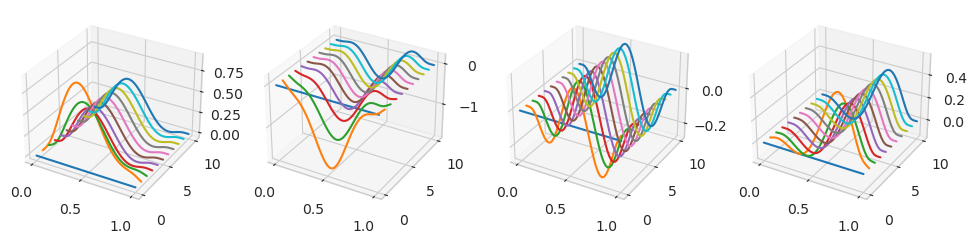

In [12]:
plt_idxs = [0,1,2,3]
ncols = len(plt_idxs)
fig = pyplot.figure(figsize=(12,4))
ax = np.empty(ncols,dtype=object)
_gs = gridspec.GridSpec(1,ncols)
for i in range(ncols): ax[i] = fig.add_subplot(_gs[0,i],projection="3d")
for i in range(ncols):
    for k in range(vopt.size(1)):
        ax[i].plot(xticks,k*torch.ones_like(xticks),vopt[plt_idxs[i],k,:nxticks])

## Data

### Train-test split

In [13]:
val_frac = 1/8
tv_idx = torch.arange(R)#torch.from_numpy(dnb2.rng.permutation(R))
n_train = R-int(val_frac*R)
n_val = R-n_train
tidx = tv_idx[:n_train]
vidx = tv_idx[n_train:]
print("number train u: %d"%n_train)
print("number val   u: %d\n"%n_val)
uticks_train = uticks[tidx]
uticks_val = uticks[vidx]
vopt_train = vopt[tidx]
vopt_val = vopt[vidx]
vticks_train = vticks[tidx]
vticks_val = vticks[vidx]
L_chols_train = L_chols[tidx]
L_chols_val = L_chols[vidx]
print("uticks_train.shape:",tuple(uticks_train.shape))
print("vopt_train.shape:",tuple(vopt_train.shape))
print("vticks_train.shape:",tuple(vticks_train.shape))
print("L_chols_train.shape:",tuple(L_chols_train.shape))
print()
print("uticks_val.shape:",tuple(uticks_val.shape))
print("vopt_val.shape:",tuple(vopt_val.shape))
print("vticks_val.shape:",tuple(vticks_val.shape))
print("L_chols_val.shape:",tuple(L_chols_val.shape))

number train u: 3584
number val   u: 512

uticks_train.shape: (3584, 51)
vopt_train.shape: (3584, 11, 104)
vticks_train.shape: (3584, 51)
L_chols_train.shape: (3584, 10, 53, 53)

uticks_val.shape: (512, 51)
vopt_val.shape: (512, 11, 104)
vticks_val.shape: (512, 51)
L_chols_val.shape: (512, 10, 53, 53)


### Torch Dataset and Dataloader

In [14]:
class DatasetCHONKNORIS(torch.utils.data.Dataset):
    def __init__(self, v, L_chols, relaxations=torch.zeros(1), device="cpu", steps="all", fp32=False, interior_only=False, common_v0=True):
        self.v = v[:,:,:nxticks] if interior_only else v
        self.relaxations = relaxations
        assert (L_chols[0,0,:,:]==L_chols[:,0,:,:]).all()
        self.L_chols = L_chols
        self.common_v0 = common_v0
        if self.common_v0:
            self.L0_inv = torch.linalg.solve_triangular(L_chols[0,0],torch.eye(L_chols.size(-1),dtype=L_chols.dtype),upper=False)
        if (relaxations==0).all():
            self.L_chols = L_chols[:,:,None,:,:]
        else:
            Thetas = torch.einsum("rikp,rimp->rikm",L_chols,L_chols)
            Thetas_relaxed = Thetas[:,:,None,:,:]+self.relaxations[:,None,None]*torch.eye(Thetas.size(-1),dtype=Thetas.dtype,device=Thetas.device)
            self.L_chols = torch.linalg.cholesky(Thetas_relaxed)
        if fp32:
            self.v = self.v.to(torch.float32)
            self.L_chols = self.L_chols.to(torch.float32)
            self.relaxations = self.relaxations.to(torch.float32)
            if self.common_v0:
                self.L0_inv = self.L0_inv.to(torch.float32)
        steps = self.L_chols.size(1) if steps=="all" else steps
        if self.common_v0:
            i_r_0,i_k_0,i_l_0 = torch.cartesian_prod(
                torch.arange(1),
                torch.arange(1),
                torch.arange(self.relaxations.size(0))).T
            i_r_p,i_k_p,i_l_p = torch.cartesian_prod(
                torch.arange(self.L_chols.size(0)),
                torch.arange(1,steps),
                torch.arange(self.relaxations.size(0))).T
            self.i_r,self.i_k,self.i_l = torch.hstack([i_r_0,i_r_p]),torch.hstack([i_k_0,i_k_p]),torch.hstack([i_l_0,i_l_p])
        else:
            self.i_r,self.i_k,self.i_l = torch.cartesian_prod(
                torch.arange(self.L_chols.size(0)),
                torch.arange(steps),
                torch.arange(self.relaxations.size(0))).T
        self._put_on_device(device)
    def _put_on_device(self, device):
        self.i_r = self.i_r.to(device)
        self.i_k = self.i_k.to(device)
        self.i_l = self.i_l.to(device)
        self.v = self.v.to(device)
        self.L_chols = self.L_chols.to(device)
        self.relaxations = self.relaxations.to(device)
        if self.common_v0:
            self.L0_inv = self.L0_inv.to(device)
    def __getitems__(self, i):
        i = torch.tensor(i,dtype=torch.int)
        ir,ik,il = self.i_r[i],self.i_k[i],self.i_l[i]
        return self.v[ir,ik,:],self.relaxations[il],self.L_chols[ir,ik,il]
    def __len__(self):
        return len(self.i_r)

## Operator-Valued Learning

### MLP

In [15]:
class MultilayerPerceptron(torch.nn.Module):
    def __init__(self, mlp_layer_nodes:list, activation_function:torch.nn.Module=torch.nn.Tanh(), activate_last_layer:bool=False, scale_last_layer:bool=True, bias_last_layer:bool=True, weight_init_scheme:callable=None, batch_norm=None):
        super().__init__()
        num_layers = len(mlp_layer_nodes)-1
        self.mlp_layer_nodes = mlp_layer_nodes
        self.output_nodes = self.mlp_layer_nodes[-1]
        layers = []
        use_batch_norm = (batch_norm is not None) and (batch_norm is not False)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore",".*Initializing zero-element tensors is a no-op*") # occurs when setting a layer with 0 inputs
            for i in range(num_layers):
                layer = torch.nn.Linear(self.mlp_layer_nodes[i],self.mlp_layer_nodes[i+1])
                if callable(weight_init_scheme):
                    weight_init_scheme(layer.weight)
                layer.bias.data.fill_(0. if self.mlp_layer_nodes[i]>0 else 1.)
                if use_batch_norm: 
                    if callable(batch_norm):
                        batch_norm_layer = batch_norm(self.mlp_layer_nodes[i+1])
                    else:
                        batch_norm_layer = torch.nn.BatchNorm1d(self.mlp_layer_nodes[i+1])
                    layers.extend([layer,batch_norm_layer,activation_function])
                else:
                    layers.extend([layer,activation_function])
        if use_batch_norm:
            self.mlp_sequential = torch.nn.Sequential(*(layers if activate_last_layer else layers[:-2]))
        else:    
            self.mlp_sequential = torch.nn.Sequential(*(layers if activate_last_layer else layers[:-1]))
        self.logscale,self.bias = torch.tensor(0.),torch.tensor(0.)
        if scale_last_layer: self.logscale = torch.nn.parameter.Parameter(self.logscale)
        if bias_last_layer: self.bias = torch.nn.parameter.Parameter(self.bias)
    def output_transform(self, x:torch.Tensor):
        return x
    def forward(self, x):
        x = self.mlp_sequential(x).squeeze()
        x = self.output_transform(x)
        return torch.exp(self.logscale)*x+self.bias

#### Lightning

In [16]:
class NORISLightningMLP(lightning.LightningModule):
    def __init__(self, mlp, automatic_optimization=True, input_relaxation=False, loss_metric="FROB", pred_inv=True, kl_flip=True, frob_loss_alpha=.5, pred_delta=True):
        super().__init__()
        self.mlp = mlp
        self.automatic_optimization = automatic_optimization
        self.input_relaxation = input_relaxation
        self.loss_metric = loss_metric.upper()
        self.pred_inv = pred_inv
        self.pred_delta = pred_delta
        self.kl_flip = kl_flip
        self.ftype = self.mlp.mlp_sequential[0].weight.dtype
        self.s0 = self.mlp.mlp_sequential[0].weight.size(1)
        self._tril_i0,self._tril_i1 = torch.tril_indices(nxticks+2,nxticks+2)
        self._diag_i = torch.arange(nxticks+2)
        self.frob_loss_alpha = frob_loss_alpha
        assert 0<self.frob_loss_alpha<1
    def to(self, device):
        super().to(device)
        self.mlp = self.mlp.to(device)
        self._tril_i0,self._tril_i1,self._diag_i = self._tril_i0.to(device),self._tril_i1.to(device),self._diag_i.to(device)
    def forward(self, v, relaxations=None):
        assert v.ndim==2
        ins = v[:,:self.s0]
        if self.input_relaxation:
            assert relaxations is not None
            ins = torch.hstack([ins,relaxations[:,None]])
        if self.pred_delta:
            L0_inv = dataset_train.L0_inv.to(v.device)
            L0_inv_diag = L0_inv.diagonal()
            delta_L_chol_hat = torch.zeros((v.size(0),nxticks+2,nxticks+2),dtype=self.ftype,device=self._tril_i0.device)
            delta_L_chol_hat[:,self._tril_i0,self._tril_i1] = self.mlp(ins)
            diags = delta_L_chol_hat[:,self._diag_i,self._diag_i]
            diags[diags<1] = torch.exp(diags[diags<1]-1)
            diags = diags-L0_inv_diag
            delta_L_chol_hat[:,self._diag_i,self._diag_i] = diags
            L_chol_hat = L0_inv+delta_L_chol_hat
        else:
            L_chol_hat = torch.zeros((v.size(0),nxticks+2,nxticks+2),dtype=self.ftype,device=self._tril_i0.device)
            L_chol_hat[:,self._tril_i0,self._tril_i1] = self.mlp(ins)
            # set diagonal to exp(x-1) if x<1 and leave as x otherwise
            diags = L_chol_hat[:,self._diag_i,self._diag_i]
            diags[diags<1] = torch.exp(diags[diags<1]-1)
            L_chol_hat[:,self._diag_i,self._diag_i] = diags
        return L_chol_hat
    def linsolve(self, y, v, relaxations=None,inference_mode=True, return_L_hat=False):
        # v should be (R,n) and y should be (R,N,K) to give L_hat which is (R,N,N) and x which is (R,N,K)
        assert y.dtype==v.dtype
        dtype = v.dtype
        yis1d = y.ndim==1
        if yis1d:
            y = y[:,None]
        assert v.ndim in [1,2] and (v.ndim+1)==y.ndim
        vis1d = v.ndim==1
        if v.ndim==1:
            v = v[None,:]
            y = y[None,:,:]
        assert v.size(0)==y.size(0)
        v,y = v.to(self.ftype),y.to(self.ftype)
        if inference_mode:
            with torch.inference_mode():
                L_hat = self.forward(v,relaxations)
        else:
            L_hat = self.forward(v)
        if self.pred_inv:
            L_hat_T = torch.transpose(L_hat,-2,-1)
            x = torch.bmm(L_hat_T,torch.bmm(L_hat,y))
        else: 
           x = torch.cholesky_solve(y,L_hat)
        x = x.to(dtype)
        x = x[0] if vis1d else x
        x = x[:,0] if yis1d else x
        if not return_L_hat:
            return x 
        else:
            L_hat = L_hat[0] if vis1d else L_hat 
            return x,L_hat
    def frob_norm(self, L_chol, L_hat):
        ogndim = L_chol.ndim
        assert ogndim in [2,3]
        if ogndim==2:
            L_chol = L_chol[None,:,:]
            L_hat = L_hat[None,:,:]
        assert L_chol.ndim==3 and L_hat.ndim==3
        if self.pred_inv:
            L_chol = torch.linalg.solve_triangular(L_chol,torch.eye(L_chol.size(-1),dtype=L_chol.dtype,device=L_chol.device),upper=False)
        diff = L_chol[:,self._tril_i0,self._tril_i1]-L_hat[:,self._tril_i0,self._tril_i1]
        fnorms = torch.sqrt(torch.mean(diff**2))
        return fnorms[0] if ogndim==2 else fnorms 
    def kl_div(self, L_chol, L_hat, kl_flip=None):
        if kl_flip is None: kl_flip = self.kl_flip
        ogndim = L_chol.ndim
        assert ogndim in [2,3]
        if ogndim==2:
            L_chol = L_chol[None,:,:]
            L_hat = L_hat[None,:,:]
        assert L_chol.ndim==3 and L_hat.ndim==3
        if self.pred_inv: # eq (C.1) in https://arxiv.org/pdf/2304.01294
            det2_true = 2*torch.log(L_chol.diagonal(dim1=-1,dim2=-2)).sum(-1)
            det2_pred = 2*torch.log(L_hat.diagonal(dim1=-1,dim2=-2)).sum(-1)
            L_chol_T = torch.transpose(L_chol,-2,-1)
            theta = torch.bmm(L_chol,L_chol_T)
            L_hat_T = torch.transpose(L_hat,-2,-1)
            traces = torch.einsum("ijk,ikl,ilj->i",L_hat,theta,L_hat_T)
            kls = 1/2*(-det2_true-det2_pred+traces-L_chol.size(-1))
        else: # https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/
            det2_true = 2*torch.log(L_chol.diagonal(dim1=-1,dim2=-2)).sum(-1)
            det2_pred = 2*torch.log(L_hat.diagonal(dim1=-1,dim2=-2)).sum(-1)
            if kl_flip:
                L_hat_T = torch.transpose(L_hat,-2,-1)
                theta_hat = torch.bmm(L_hat,L_hat_T)
                t = torch.cholesky_solve(theta_hat,L_chol) # more efficient way to do this? 
                traces = t.diagonal(dim1=-1,dim2=-2).sum(-1)
                det_diff = det2_true-det2_pred
            else:
                L_chol_T = torch.transpose(L_chol,-2,-1)
                theta = torch.bmm(L_chol,L_chol_T)
                t = torch.cholesky_solve(theta,L_hat) # more efficient way to do this? 
                traces = t.diagonal(dim1=-1,dim2=-2).sum(-1)
                det_diff = det2_pred-det2_true
            kls = 1/2*(det_diff-L_chol.size(-1)+traces)
        return kls
    def _common_step(self, batch, tag):
        v,relaxations,L_chol = batch
        L_hat = self.forward(v,relaxations)
        if self.loss_metric=="FROB": # mean (Frobineous norm)
            loss = torch.mean(self.frob_norm(L_chol,L_hat))
        elif self.loss_metric=="KL": # mean (KL div)
            loss = torch.mean(self.kl_div(L_chol,L_hat))
        elif self.loss_metric=="FROB_KL": # mean ( frob_loss_alpha*(Frobineious norm) + (1-frob_loss_alpha)*(KL div) )
            frobs = self.frob_norm(L_chol,L_hat)
            kls = self.kl_div(L_chol,L_hat)
            loss = torch.mean(2*(self.frob_loss_alpha*frobs+(1-self.frob_loss_alpha)*kls))
        else:
            raise Exception("invalid loss_metric")
        self.log(tag+"_loss",loss,logger=True,sync_dist=True,on_step=False,on_epoch=True,prog_bar=True)#tag!="val")
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(True):
          return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=1e-3,amsgrad=True)
        # if self.trainer.current_epoch>=2000:
        #     optimizer = torch.optim.LBFGS(self.parameters())#,lr=1e-2,amsgrad=True)
        return optimizer

#### Training

In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()

relaxations = torch.tensor([.01])
dataset_train = DatasetCHONKNORIS(vopt_train,L_chols_train,relaxations=relaxations,device=DEVICE,steps=8,fp32=False,interior_only=True)
dataset_val = DatasetCHONKNORIS(vopt_val,L_chols_val,relaxations=relaxations,device=DEVICE,steps=8,fp32=False,interior_only=True)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=2**8,collate_fn=tuple,shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=len(dataset_val),collate_fn=tuple,shuffle=False)

save_dir = ROOT+"/"
name = "NORIS_MLP"
resume = True

mlp = MultilayerPerceptron(
    #mlp_layer_nodes = [2*nxticks+2,500,100,1500,1750,2000,1750,(1+(nxticks+2))*(nxticks+2)//2],
    mlp_layer_nodes = [nxticks,500,1000,(1+(nxticks+2))*(nxticks+2)//2],
    #mlp_layer_nodes = [nxticks,250,500,750,1000,1250,(1+(nxticks+2))*(nxticks+2)//2],
    #mlp_layer_nodes = [2*nxticks+2,250,500,750,1000,1250,(1+(nxticks+2))*(nxticks+2)//2],
    #activation_function = torch.nn.LogSigmoid(),
    activation_function = torch.nn.Tanh(),
    #activation_function = torch.nn.SiLU(),
    #weight_init_scheme = torch.nn.init.kaiming_normal_,
    #weight_init_scheme = torch.nn.init.xavier_normal_,
    batch_norm = False)

mlp = mlp.to(torch.float64)
noris_mlp = NORISLightningMLP(mlp,
                                    automatic_optimization=True,
                                    loss_metric="FROB",
                                    pred_inv=True,
                                    pred_delta=True)

assert noris_mlp.ftype==dataset_train.v.dtype
print()
print("number train: %.2e"%len(dataset_train))
print("number val  : %.2e"%len(dataset_val))
print()
print(noris_mlp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 500,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    gradient_clip_val = 1.0,
    gradient_clip_algorithm = "norm",
  )
trainer.fit(
    model = noris_mlp, 
    train_dataloaders = dataloader_train,
    val_dataloaders = dataloader_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./NORIS_MLP/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./NORIS_MLP/csv/checkpoints exists and is not empty.
Restoring states from the checkpoint path at ././/NORIS_MLP/csv/checkpoints/epoch=314-step=31185.ckpt
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/sit


number train: 2.51e+04
number val  : 3.58e+03

NORISLightningMLP(
  (mlp): MultilayerPerceptron(
    (mlp_sequential): Sequential(
      (0): Linear(in_features=51, out_features=500, bias=True)
      (1): Tanh()
      (2): Linear(in_features=500, out_features=1000, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1000, out_features=1431, bias=True)
    )
  )
)



Sanity Checking: |                             | 0/? [00:00<?, ?it/s]

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.


Training: |                                    | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


train_loss  val_loss
1      0.007230  0.008258
19     0.005458  0.007144
37     0.004899  0.006063
55     0.004396  0.006728
73     0.004203  0.005017
91     0.003391  0.006375
109    0.003131  0.004748
127    0.002543  0.004826
145    0.002329  0.005403
163    0.002514  0.003530
181    0.002007  0.003202

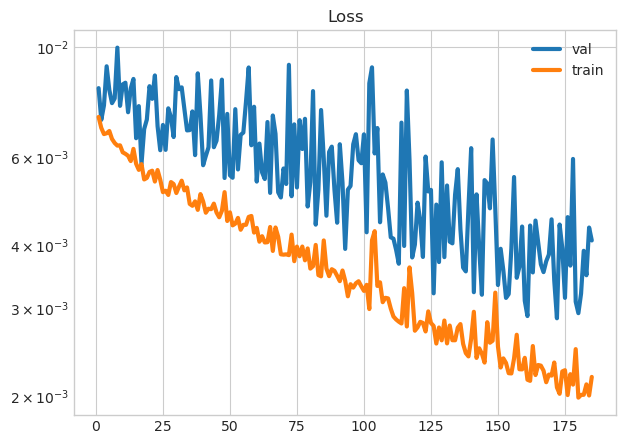

In [22]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics_train = metrics.iloc[~np.isnan(metrics["train_loss"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_loss"].values)]
metrics
parsed_metrics = {
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
}
metrics = pd.DataFrame(parsed_metrics)
metrics.index = metrics.index+1
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(7,5))
ax.set_title(r"Loss")
epochs = len(metrics.index)
plt_epochs = metrics.index#[epochs//10:]
ax.plot(plt_epochs,metrics["val_loss"][plt_epochs],label="val",linewidth=LW)
ax.plot(plt_epochs,metrics["train_loss"][plt_epochs],label="train",linewidth=LW)
ax.legend()
ax.set_yscale("log",base=10);
metrics.iloc[::max(1,len(metrics)//10)]

### GP

In [83]:
#https://docs.gpytorch.ai/en/latest/examples/04_Variational_and_Approximate_GPs/SVGP_Multitask_GP_Regression.html
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        #self.mean_module = gpytorch.means.LinearMean(input_size=2*nxticks,batch_shape=torch.Size([nxticks]))
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([(1+(nxticks+2))*(nxticks+2)//2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims = None, 
                #ard_num_dims = 2*nxticks, 
                batch_shape=torch.Size([(1+(nxticks+2))*(nxticks+2)//2])),
            batch_shape=torch.Size([(1+(nxticks+2))*(nxticks+2)//2]))
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x))
class IndependentMultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_tasks, num_inducing_pts):
        inducing_points = torch.rand(num_tasks, num_inducing_pts, nxticks)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_pts, batch_shape=torch.Size([num_tasks]))
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True),
            num_tasks=num_tasks)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_tasks]))            
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_tasks])),
            batch_shape=torch.Size([num_tasks]))
        self.num_tasks = num_tasks
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing_pts, num_tasks, num_latents, num_inputs):
        inducing_points = torch.rand(num_latents, num_inducing_pts, num_inputs)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_pts,batch_shape=torch.Size([num_latents]))
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents]))
        self.num_tasks = num_tasks
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Lightning

In [94]:
class NORISLightningGP(lightning.LightningModule):
    def __init__(self, gp, automatic_optimization=True, input_relaxation=False, special_prior_mean=False, fixed_noise=False):
        super().__init__()
        self.gp = gp
        self.automatic_optimization = automatic_optimization
        self.input_relaxation = input_relaxation
        self.pred_inv = True
        self.ftype = gp.variational_strategy.base_variational_strategy.inducing_points.dtype
        self.s0 = gp.variational_strategy.base_variational_strategy.inducing_points.size(-1)
        self._tril_i0,self._tril_i1 = torch.tril_indices(nxticks+2,nxticks+2)
        self._diag_i = torch.arange(nxticks+2)
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=self.gp.num_tasks)
        self.mll = gpytorch.mlls.VariationalELBO(likelihood,self.gp,num_data=self.s0)
        if special_prior_mean:
            self.gp.mean_module.initialize(constant=L_inv_chols[0,0,self._tril_i0,self._tril_i1])
            #self.gp.mean_module.constant.requires_grad = False
        if fixed_noise:
            self.mll.likelihood.task_noises[:] = -10
            self.mll.likelihood.raw_task_noises.requires_grad_(False)
    def to(self, device):
        super().to(device)
        self.gp = self.gp.to(device)
        self.mll.likelihood = self.mll.likelihood.to(device)
        self._tril_i0,self._tril_i1,self._diag_i = self._tril_i0.to(device),self._tril_i1.to(device),self._diag_i.to(device)
    def forward_mvn(self, v, relaxations=None):
        assert v.ndim==2
        ins = v[:,:self.s0]
        if self.input_relaxation:
            assert relaxations is not None
            ins = torch.hstack([ins,relaxations[:,None]])
        return self.gp(ins)
    def forward(self, v, relaxations=None):
        outs = self.forward_mvn(v,relaxations)
        L_chol_hat = torch.zeros((v.size(0),nxticks+2,nxticks+2),dtype=self.ftype,device=self._tril_i0.device)
        L_chol_hat[:,self._tril_i0,self._tril_i1] = outs.mean
        return L_chol_hat
    def linsolve(self, y, v, relaxations=None, inference_mode=True, return_L_hat=False):
        # v should be (R,n) and y should be (R,N,K) to give L_hat which is (R,N,N) and x which is (R,N,K)
        assert y.dtype==v.dtype
        dtype = v.dtype
        yis1d = y.ndim==1
        if yis1d:
            y = y[:,None]
        assert v.ndim in [1,2] and (v.ndim+1)==y.ndim
        vis1d = v.ndim==1
        if v.ndim==1:
            v = v[None,:]
            y = y[None,:,:]
        assert v.size(0)==y.size(0)
        v,y = v.to(self.ftype),y.to(self.ftype)
        if inference_mode:
            with torch.inference_mode():
                L_hat = self.forward(v,relaxations)
        else:
            L_hat = self.forward(v)
        if self.pred_inv:
            L_hat_T = torch.transpose(L_hat,-2,-1)
            x = torch.bmm(L_hat_T,torch.bmm(L_hat,y))
        else: 
           x = torch.cholesky_solve(y,L_hat)
        x = x.to(dtype)
        x = x[0] if vis1d else x
        x = x[:,0] if yis1d else x
        if not return_L_hat:
            return x 
        else:
            L_hat = L_hat[0] if vis1d else L_hat 
            return x,L_hat
    def _common_step(self, batch, tag):
        v,relaxations,L_chol = batch
        L_chol_inv = torch.linalg.solve_triangular(L_chol,torch.eye(L_chol.size(-1),dtype=L_chol.dtype,device=L_chol.device),upper=False)
        out = self.forward_mvn(v,relaxations)
        loss = -self.mll(out,L_chol_inv[:,self._tril_i0,self._tril_i1])
        fnorm = torch.sqrt(torch.mean((out.mean-L_chol_inv[:,self._tril_i0,self._tril_i1])**2))
        self.log(tag+"_loss",loss,logger=True,sync_dist=True,on_step=False,on_epoch=True,prog_bar=True)#tag!="val")
        self.log(tag+"_fnorm",fnorm,logger=True,sync_dist=True,on_step=False,on_epoch=True,prog_bar=True)#tag!="val")
        return loss
    def training_step(self, batch, batch_idx):
        self.gp.train()
        self.mll.likelihood.train()
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        self.gp.eval()
        self.mll.likelihood.eval()
        with torch.inference_mode(True):
          return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=5e-2,amsgrad=True)
        # if self.trainer.current_epoch>=2000:
        #     optimizer = torch.optim.LBFGS(self.parameters())#,lr=1e-2,amsgrad=True)
        return optimizer

#### Training

In [95]:
save_dir = ROOT+"/"
name = "NORIS_GP"
resume = False

import gc
gc.collect()
torch.cuda.empty_cache()

#gp = BatchIndependentMultitaskGPModel(
#gp = IndependentMultitaskGPModel(num_inducing_pts=25, num_tasks=(1+(nxticks+2))*(nxticks+2)//2)
gp = MultitaskGPModel(num_inducing_pts=100, num_tasks=(1+(nxticks+2))*(nxticks+2)//2, num_latents=100, num_inputs=nxticks)
gp = gp.double()


noris_gp = NORISLightningGP(gp, 
                 automatic_optimization = True, 
                 input_relaxation = False,
                 special_prior_mean = False,
                 fixed_noise = False)

assert noris_gp.ftype==dataset_train.v.dtype
print()
print("number train: %.2e"%len(dataset_train))
print("number val  : %.2e"%len(dataset_val))
print()
print(noris_gp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 100,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    gradient_clip_val = 1.0,
    gradient_clip_algorithm = "norm",
  )

relaxations = torch.tensor([0])
dataset_train = DatasetCHONKNORIS(vopt_train,L_chols_train,relaxations=relaxations,device=DEVICE,steps=8,fp32=False,interior_only=True)
dataset_val = DatasetCHONKNORIS(vopt_val,L_chols_val,relaxations=relaxations,device=DEVICE,steps=8,fp32=False,interior_only=True)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=2**10,collate_fn=tuple,shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=len(dataset_val),collate_fn=tuple,shuffle=False)


trainer.fit(
    model = noris_gp, 
    train_dataloaders = dataloader_train,
    val_dataloaders = dataloader_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)


# model.train()
# likelihood.train()
# training_iterations = 3
# optimizer = torch.optim.Adam([{'params': model.parameters()},{'params': likelihood.parameters()},],lr=.1,amsgrad=True)

# verbosity = max(1,int(training_iterations/20))
# for i in range(training_iterations):
#     optimizer.zero_grad()
#     output = model(v_gp_train)
#     loss = -mll(output,L_inv_gp_train[:,_tril_i0,_tril_i1])
#     loss.backward()
#     if (i+1)%verbosity==0: print('Iter %3d/%-3d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
#     optimizer.step()

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./NORIS_GP/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./NORIS_GP/csv/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type             | Params | Mode 
--------------------------------------------------
0 | g


number train: 2.51e+04
number val  : 3.58e+03

NORISLightningGP(
  (gp): MultitaskGPModel(
    (variational_strategy): LMCVariationalStrategy(
      (base_variational_strategy): VariationalStrategy(
        (_variational_distribution): CholeskyVariationalDistribution()
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (mll): VariationalELBO(
    (likelihood): MultitaskGaussianLikelihood(
      (raw_task_noises_constraint): GreaterThan(1.000E-04)
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
    (model): MultitaskGPModel(
      (variational_strategy): LMCVariationalStrategy(
        (base_variational_strategy): VariationalStrategy(
          (_variational_distribution): CholeskyVariationalDistribution()
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
      

Sanity Checking: |                             | 0/? [00:00<?, ?it/s]

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                    | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

train_loss     val_loss  train_fnorm  val_fnorm
1   11416.649673  2474.628662     0.160549   0.106380
7   -1676.932260 -2055.503798     0.037154   0.036201
13  -3178.375214 -2374.172024     0.030258   0.040857
19  -3747.016748 -3751.768478     0.020971   0.021481
25  -3850.273512 -3844.121186     0.020950   0.021152
31  -3446.926712 -3379.458611     0.025850   0.025707
37  -3610.977323 -3633.304406     0.022179   0.021770
43  -3858.404103 -3866.726034     0.021722   0.021282
49  -3819.855754 -3824.109368     0.022714   0.022581
55  -3774.210837 -3806.182193     0.022823   0.022678
61  -3880.622332 -3893.104756     0.021373   0.021282

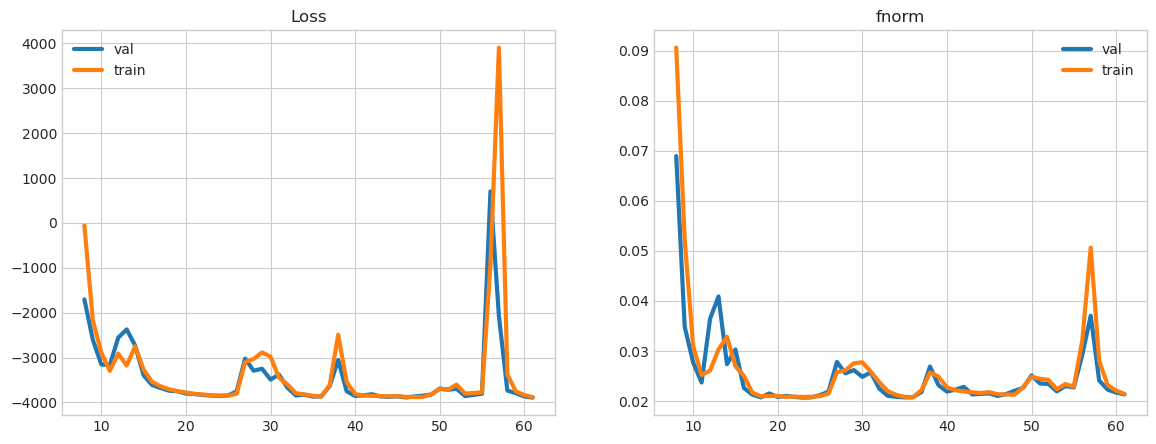

In [96]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics_train = metrics.iloc[~np.isnan(metrics["train_loss"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_loss"].values)]
parsed_metrics = {
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
    "train_fnorm": metrics_train["train_fnorm"].values,
    "val_fnorm": metrics_val["val_fnorm"].values,
}
metrics = pd.DataFrame(parsed_metrics)
metrics.index = metrics.index+1
metrics
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(14,5))
epochs = len(metrics.index)
plt_epochs = metrics.index[epochs//8:]
ax[0].set_title(r"Loss")
ax[0].plot(plt_epochs,metrics["val_loss"][plt_epochs],label="val",linewidth=LW)
ax[0].plot(plt_epochs,metrics["train_loss"][plt_epochs],label="train",linewidth=LW)
ax[0].legend()
ax[1].set_title(r"fnorm")
ax[1].plot(plt_epochs,metrics["val_fnorm"][plt_epochs],label="val",linewidth=LW)
ax[1].plot(plt_epochs,metrics["train_fnorm"][plt_epochs],label="train",linewidth=LW)
ax[1].legend()
metrics.iloc[::max(1,len(metrics)//10)]

## Inference

In [97]:
noris = noris_mlp
#noris = noris_gp

In [98]:
class NORISPrecond(qp.kernel_methods.pcg_module.preconditioners._BasePrecond):
    def __init__(self, v):
        self.v = v
    def solve(self, y):
        x = noris.linsolve(y,self.v)
        return x

In [100]:
noris.eval()
noris.to("cpu")
ridxs = [0,1,2,7]
maxiter = 10
numrs = len(ridxs)
vhat = [None]*numrs
numpreds = maxiter+1
data_refs = [None]*numrs
datas = [None]*numrs
L_chol_hats = torch.nan*torch.empty((numrs,maxiter,L_chols.size(-1),L_chols.size(-1)),dtype=noris.ftype)
for i,r in enumerate(ridxs):
    print("ridxs[%d] = %d"%(i,r))
    L_chols_hats_i = [None]*maxiter
    j = 0
    def custom_lin_solver(v, y):
        global j
        x,L_chol_hats[i,j] = noris.linsolve(y,v,return_L_hat=True)
        j += 1
        return x
    def pde_lhs_r(ly_i, ly_b):
        v_i,v_laplace_i = ly_i
        v_b = ly_b[0]
        lhs_i = C1*v_i**3+C2*v_laplace_i
        lhs_b = v_b
        return lhs_i,lhs_b
    def pde_rhs_r(x_i, x_b):
        y_i = uticks_val[r]
        y_b = torch.zeros(len(x_b),dtype=float)
        return y_i,y_b
    # print("  Chol Direct")
    # y,datas[i] = ki.pde_opt_gauss_newton(
    #         pde_lhs = pde_lhs_r,
    #         pde_rhs = pde_rhs_r,
    #         maxiter = maxiter,
    #         custom_lin_solver = custom_lin_solver,
    #         verbose = 1)
    print("  True CG")
    y_ref_r,data_refs[i] = ki.pde_opt_gauss_newton(
        pde_lhs = pde_lhs_r,
        pde_rhs = pde_rhs_r,
        maxiter = maxiter,
        precond_setter = lambda x: qp.kernel_methods.IdentityPrecond(),#lambda pde_gm: NORISPrecond(pde_gm.z),
        verbose = 2)
    print("  Neural PCG")
    y_r,datas[i] = ki.pde_opt_gauss_newton(
        pde_lhs = pde_lhs_r,
        pde_rhs = pde_rhs_r,
        maxiter = maxiter,
        precond_setter = lambda pde_gm: NORISPrecond(pde_gm.z),
        verbose = 2)
    vhat[i] = datas[i]["zhist"][:,:nxticks]
    print()
vhat = torch.stack(vhat)
l2rerrors = torch.linalg.norm(vhat-vticks_val[ridxs,None,:],dim=2)/torch.linalg.norm(vticks_val[ridxs,None,:],dim=2)
l2rerrors_iter = torch.linalg.norm(vhat[:,:min(vopt_val.size(1),numpreds),:]-vopt_val[ridxs,:numpreds,:nxticks],dim=2)/torch.linalg.norm(vopt_val[ridxs,:numpreds,:nxticks],dim=2)
aerrors = torch.abs(vhat[:,-1,:]-vticks_val[ridxs,:])
with np.printoptions(precision=1):
    print("l2rerrors_iter")
    print(l2rerrors_iter.numpy())
    print()
    print("l2rerrors")
    print(l2rerrors.numpy())
    print()

ridxs[0] = 0
  Chol Direct
    iter (10 max)  loss           time           
    0              1.31e-01                      
    1              1.48e+00       nan            
    2              9.36e+00       nan            
    3              3.75e+05       nan            
    4              7.59e+35       nan            
    5              inf            nan            
    6              nan            nan            
    7              nan            nan            
    8              nan            nan            
    9              nan            nan            
    10             nan            nan            
  True CG
    iter (10 max)  loss           time           K(A)           K(P)           K(P)/K(A)      PCG rberror    PCG steps (53 max)
    0              1.31e-01                      
    1              3.60e-01       4.22e-03       4.6e+05        4.6e+05        1.0e+00        5.8e-03        53
    2              9.23e-02       7.55e-03       4.5e+04        4.5e+04  

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/IPython/core/events.py:82
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:170


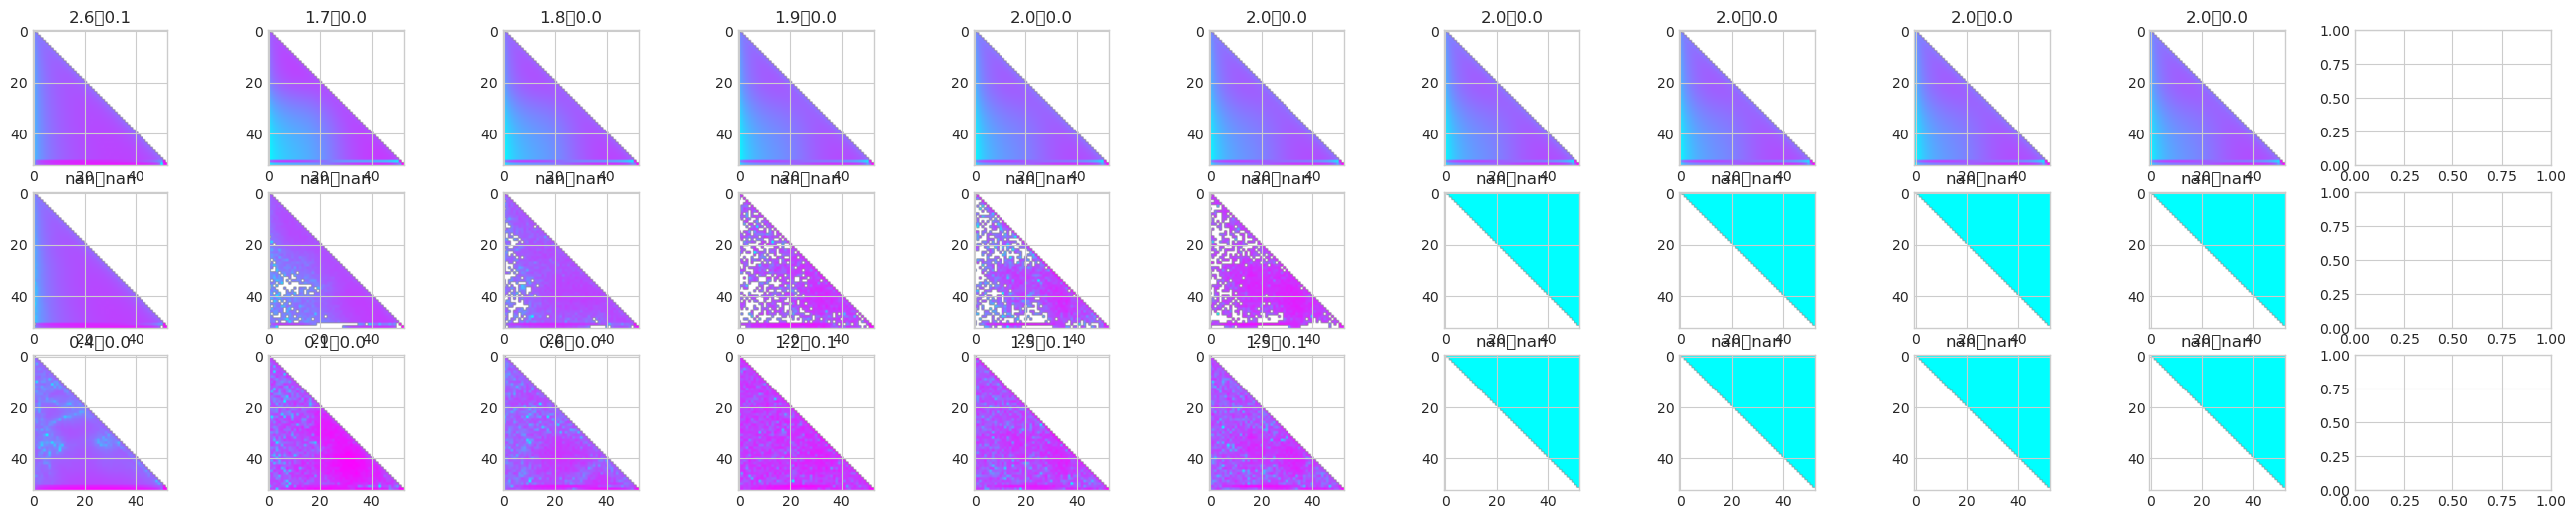

In [101]:
fig,ax = pyplot.subplots(nrows=3,ncols=numpreds,figsize=(3*numpreds,3*2))
for k in range(maxiter):
    L_inv_true = torch.linalg.solve_triangular(
        L_chols_val[ridxs[0],k],
        torch.eye(nxticks+2,dtype=L_chols_val.dtype),
        upper=False)
    err = (L_chol_hats[0,k]-L_inv_true.cpu()).abs()
    ax[0,k].imshow(L_inv_true.abs(),norm=colors.LogNorm(),cmap=cm.cool)
    ax[0,k].set_title("%.1f\t%.1f"%(L_inv_true.abs().max(),L_inv_true.abs().mean()))
    ax[1,k].imshow(L_chol_hats[0,k],norm=colors.LogNorm(),cmap=cm.cool)
    ax[1,k].set_title("%.1f\t%.1f"%(L_chol_hats.abs().max(),L_chol_hats.abs().mean()))
    ax[2,k].imshow(err,norm=colors.LogNorm(),cmap=cm.cool)
    ax[2,k].set_title("%.1f\t%.1f"%(err.abs().max(),err.abs().mean()))

In [102]:
# fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(7,5))
# for i in range(numrs):
#     ax.plot(torch.cat(data_refs[i]["times"]),color=COLORS[i]);
#     ax.plot(torch.cat(datas[i]["times"]),color=COLORS[i],linestyle="--");

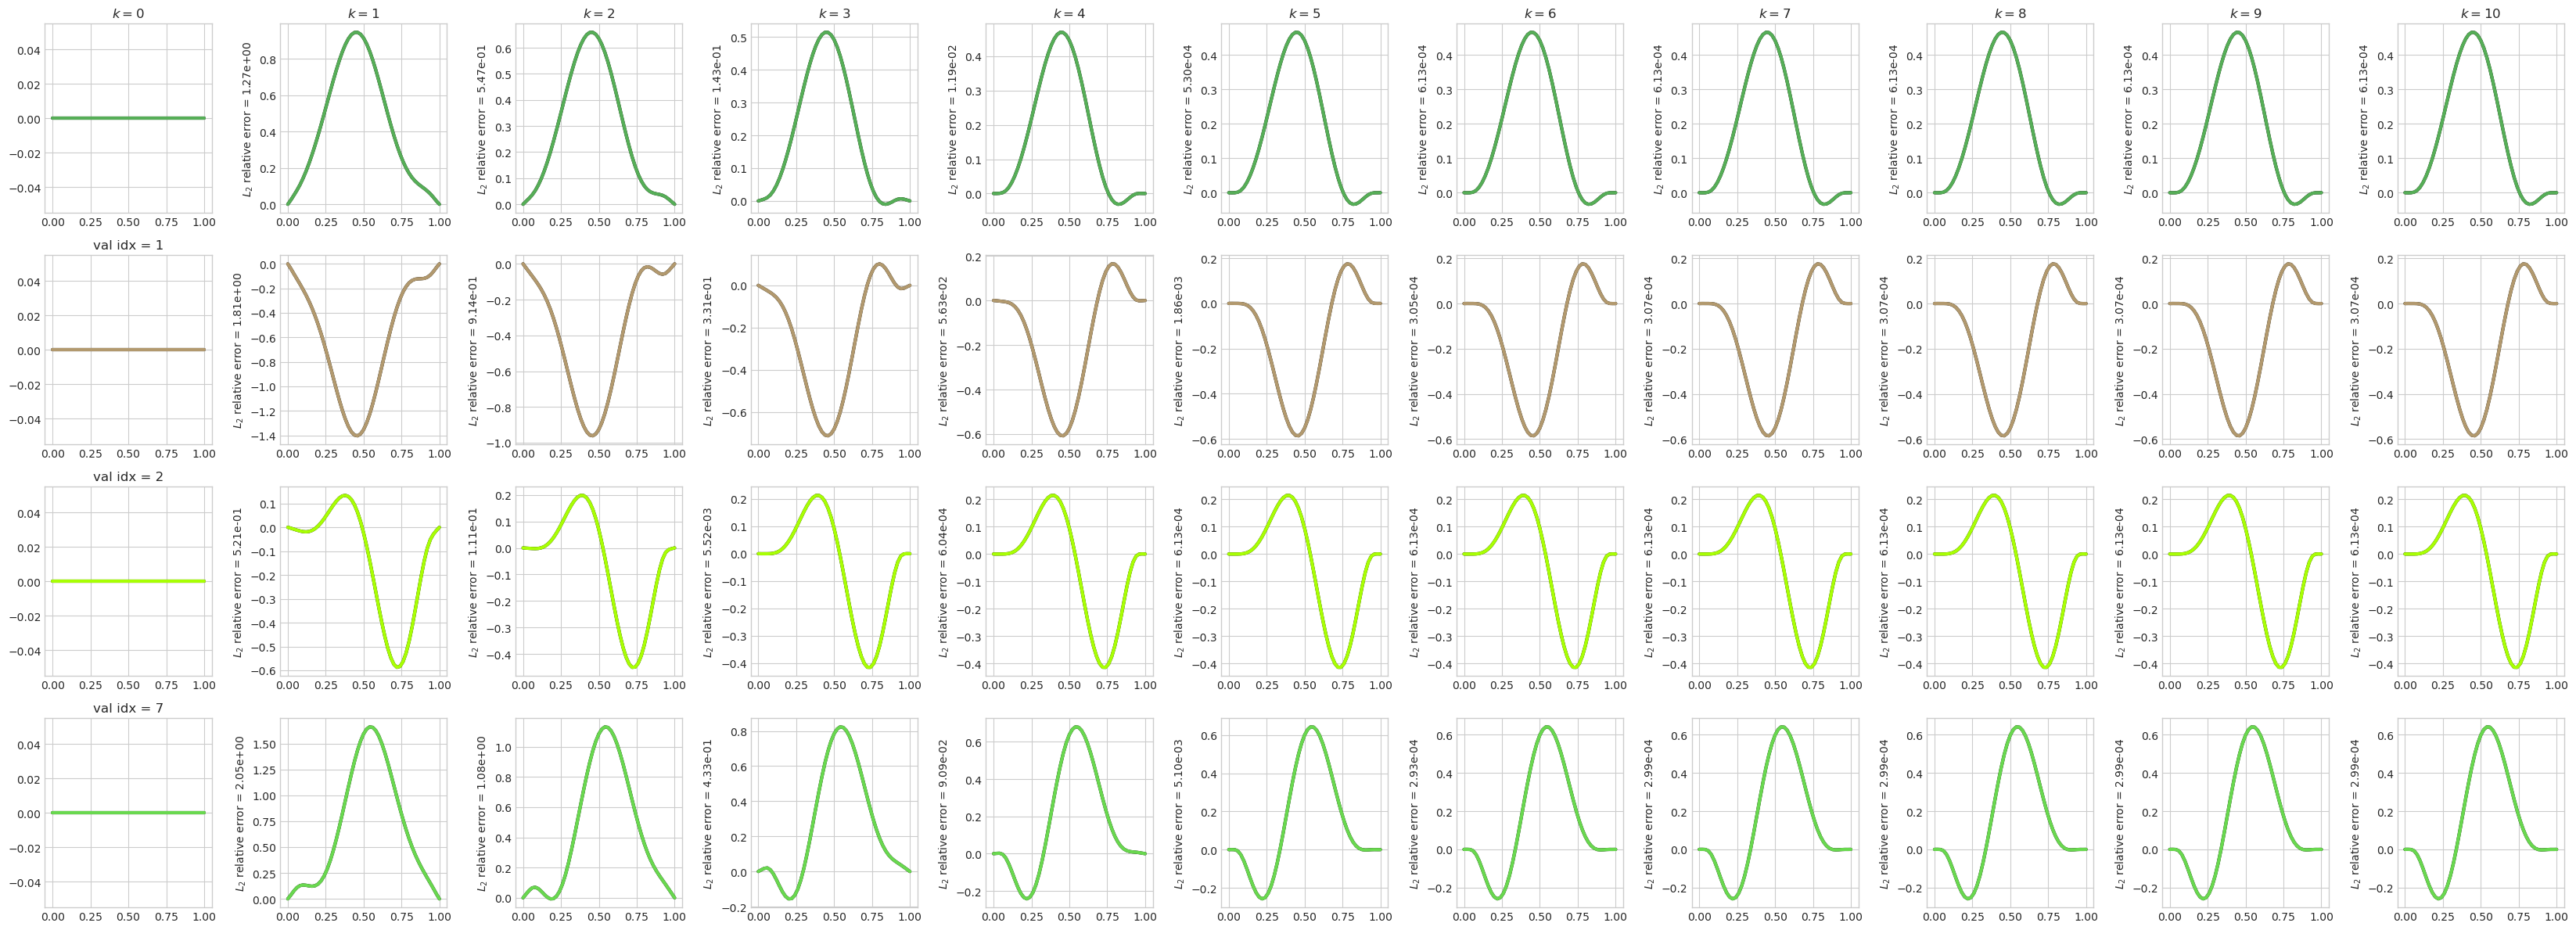

In [103]:
fig,ax = pyplot.subplots(nrows=numrs,ncols=numpreds,figsize=(3*numpreds,3*numrs))
for i in range(numrs):
    #ymin,ymax = vhat[i,:,:nxticks].min(),vhat[i,:,:nxticks].max()
    ymin,ymax = vhat.min(),vhat.max()
    yymin,yymax = ymin-(ymax-ymin)*.1,ymax+(ymax-ymin)*.1
    for k in range(numpreds):
        if k<vopt.size(1):
            ax[i,k].plot(xticks,vopt_val[ridxs[i],k,:nxticks],linewidth=LW,color="k")
        ax[i,k].plot(xticks,vhat[i,k,:nxticks],linewidth=LW,color=COLORS[i])
        #ax[i,k].set_ylim([yymin,yymax])
        if k>0:
            ax[i,k].set_ylabel(r"$L_2$ relative error = %.2e"%l2rerrors[i,k])
for i in range(numrs):
    ax[i,0].set_title("val idx = %d"%ridxs[i])
for k in range(numpreds):
    ax[0,k].set_title(r"$k = %d$"%k)
fig.tight_layout()

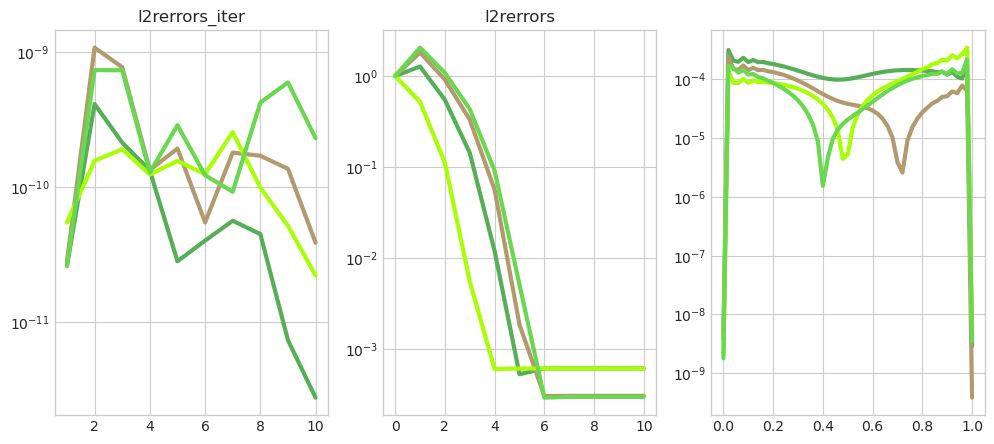

In [104]:
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=((12,5)))
for i in range(numrs):
    ax[0].plot(torch.arange(len(l2rerrors_iter[i])),l2rerrors_iter[i],linewidth=LW,color=COLORS[i])
    ax[1].plot(torch.arange(numpreds),l2rerrors[i],linewidth=LW,color=COLORS[i])
    ax[2].plot(xticks,aerrors[i],linewidth=LW,color=COLORS[i])
ax[0].set_title("l2rerrors_iter")
ax[1].set_title("l2rerrors")
for i in range(3):
    ax[i].set_yscale("log",base=10)

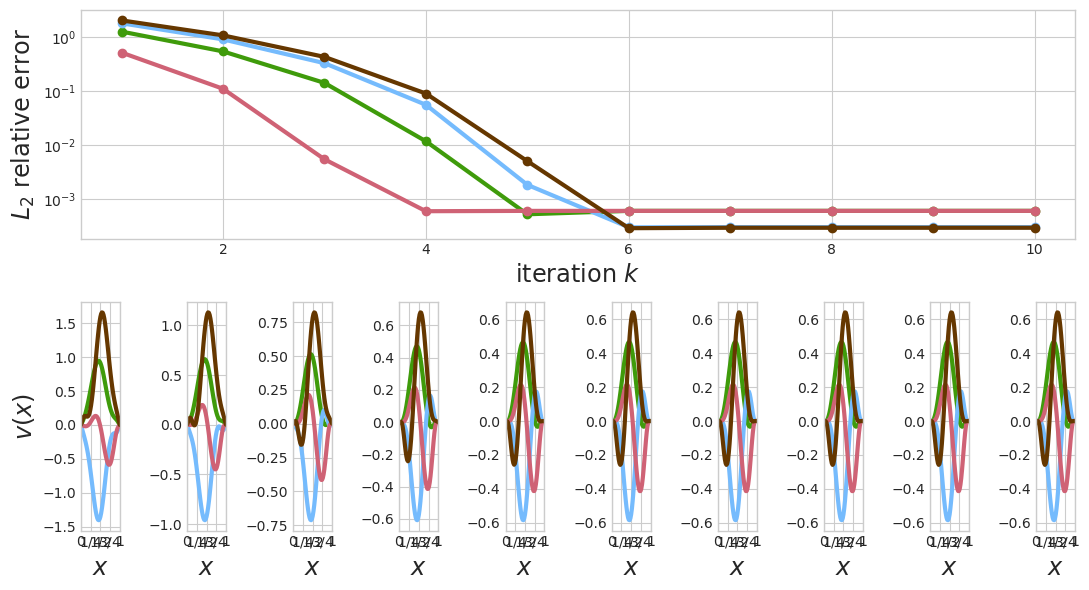

In [105]:
fig = pyplot.figure(figsize=(11,6))
_gs = gridspec.GridSpec(2,numpreds-1) 
CUSTOMCOLORS = ["xkcd:grass green","xkcd:sky blue","xkcd:rose","xkcd:brown"]+COLORS
ax = fig.add_subplot(_gs[0,:])
for i in range(numrs):
    ax.plot(torch.arange(1,numpreds),l2rerrors[i,1:],marker="o",linewidth=LW,color=CUSTOMCOLORS[i])
ax.set_yscale("log",base=10)
ax.set_xlim([.6,numpreds-.6])
ax.set_xlabel(r"iteration $k$",fontsize="xx-large")
ax.set_ylabel(r"$L_2$ relative error",fontsize="xx-large")
ax = np.empty(numpreds-1,dtype=object)
for k in range(numpreds-1):
    ax[k] = fig.add_subplot(_gs[1,k])
    ax[k].set_xlim([0,1])
    ax[k].set_xticks([0,1/4,1/2,3/4,1])
    ax[k].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
    #ax[k].set_ylim([ymin-.05*(ymax-ymin),ymax+.05*(ymax-ymin)])
    ax[k].set_xlabel(r"$x$",fontsize="xx-large")
ymin,ymax = vhat[:,1:numpreds,:nxticks].min(),vhat[:,1:numpreds,:nxticks].max()
for k in range(numpreds-1):
    for i in range(numrs):
        ax[k].plot(xticks,vhat[i,k+1,:nxticks],linewidth=LW,color=CUSTOMCOLORS[i])
for k in range(1,numpreds-1):
    pass#ax[k].set_yticklabels([""]*len(ax[k].get_yticklabels()))#get_yaxis().set_visible(False)
ax[0].set_ylabel(r"$v(x)$",fontsize="xx-large")
fig.tight_layout()
#fig.savefig("./superres.png",dpi=512,bbox_inches="tight")